In [1]:
# -*- coding: utf-8 -*-
import sys; print('Python %s on %s' % (sys.version, sys.platform))
import os
import time
import json
from glob import glob, iglob
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np; print('numpy', np.__version__)
import pandas as pd; print('pandas', pd.__version__)
import cv2; print('opencv2', cv2.__version__)
import sklearn; print('sklearn', sklearn.__version__)
import tensorflow as tf; print('tensorflow', tf.__version__)
import tensorflow.keras as keras; print('keras', keras.__version__)

import settings
import helper
import visual

Python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]] on linux
numpy 1.16.4
pandas 0.24.2
opencv2 4.1.0
sklearn 0.21.2
tensorflow 1.14.0
keras 2.2.4-tf


# 1. Load Meta File and Annotation

In [2]:
df_meta_train = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_TRAIN_META_FILE, index_col=['seriesuid'])
df_meta_train.index = df_meta_train.index.astype('str')
df_meta_test = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_TEST_META_FILE, index_col=['seriesuid'])
df_meta_test.index = df_meta_test.index.astype('str')

print('meta_train:', df_meta_train.shape, '\n', 'meta_test:', df_meta_test.shape)

meta_train: (1470, 10) 
 meta_test: (145, 10)


In [3]:
df_annotation = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_ANNOTATION_FILE, index_col=['seriesuid'])
df_annotation.index = df_annotation.index.astype('str')
df_annotation['label'] = df_annotation['label'].astype('int')
print('annotation:', df_annotation.shape, 'distinct lung:', len(set(df_annotation.index)))

annotation: (12218, 16) distinct lung: 1436


In [4]:
df_annotation.sample(10)

,width,height,slice,vcoordX,vcoordY,vcoordZ,diameterX,diameterY,diameterZ,originX,originY,originZ,spacingX,spacingY,spacingZ,label
seriesuid,,,,,,,,,,,,,,,,
671748,350,350,250,187.988281,214.648438,180.0,3.417969,6.152344,5.0,-155.048233,-174.658203,1283.005127,0.683594,0.683594,5.0,31
522706,370,370,252,188.251891,170.185491,42.0,10.117184,8.671872,7.0,-189.899994,-185.000000,-816.700012,0.722656,0.722656,7.0,31
527797,264,264,290,172.734375,135.867188,205.0,7.734375,8.250000,5.0,-141.742188,-270.742188,-531.000000,0.515625,0.515625,5.0,31
675937,350,350,285,232.080078,244.726562,153.0,8.203125,11.621094,10.0,-161.584900,-174.658203,-100.071533,0.683594,0.683594,5.0,5
656221,350,350,270,278.906250,175.000000,165.0,4.785156,6.152344,5.0,-172.479324,-174.658203,-56.745972,0.683594,0.683594,5.0,1
525893,426,426,275,203.015625,260.425781,102.0,7.488281,12.480469,10.0,-195.583984,-352.583984,-358.600006,0.832031,0.832031,5.0,31
680265,350,350,325,258.056641,224.902344,145.0,5.468750,4.785156,5.0,-184.826355,-174.658203,-366.706055,0.683594,0.683594,5.0,1
697234,386,386,250,255.197266,128.164062,170.0,6.031250,6.785156,5.0,-182.623047,-332.623047,-672.599976,0.753906,0.753906,5.0,1
683084,350,350,260,223.193359,179.785156,230.0,6.835938,6.152344,5.0,-176.837097,-174.658203,-86.550171,0.683594,0.683594,5.0,1


annotation 结节[1] (3264, 16)


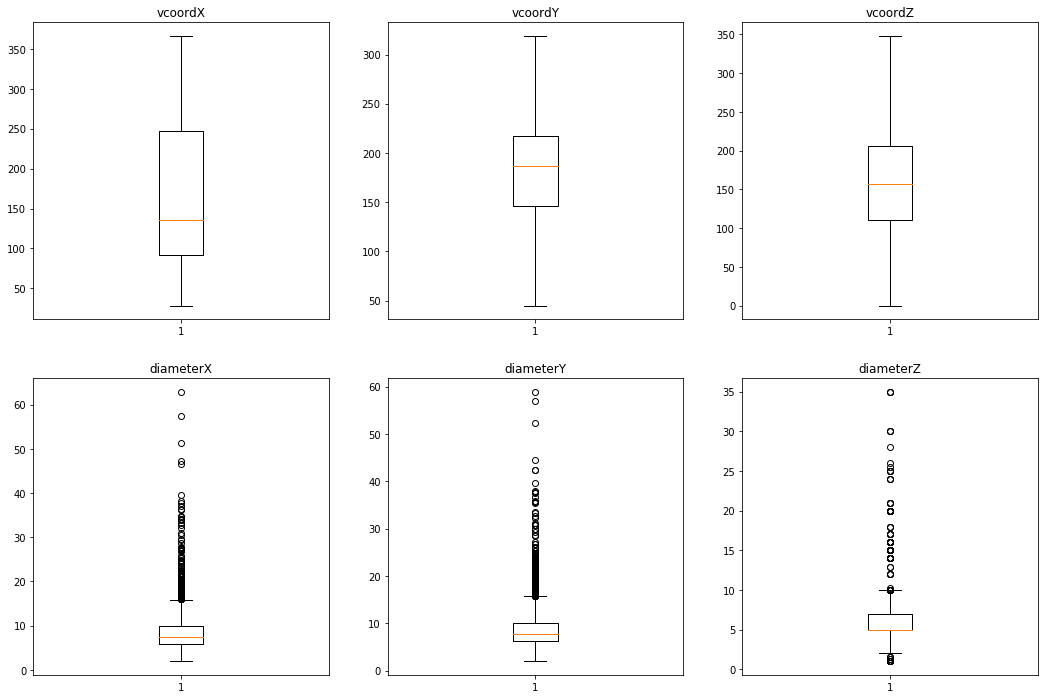

In [5]:
visual.plot_annotation(df_annotation[df_annotation['label']==1], title='annotation 结节[1]')

annotation 索条[5] (3613, 16)


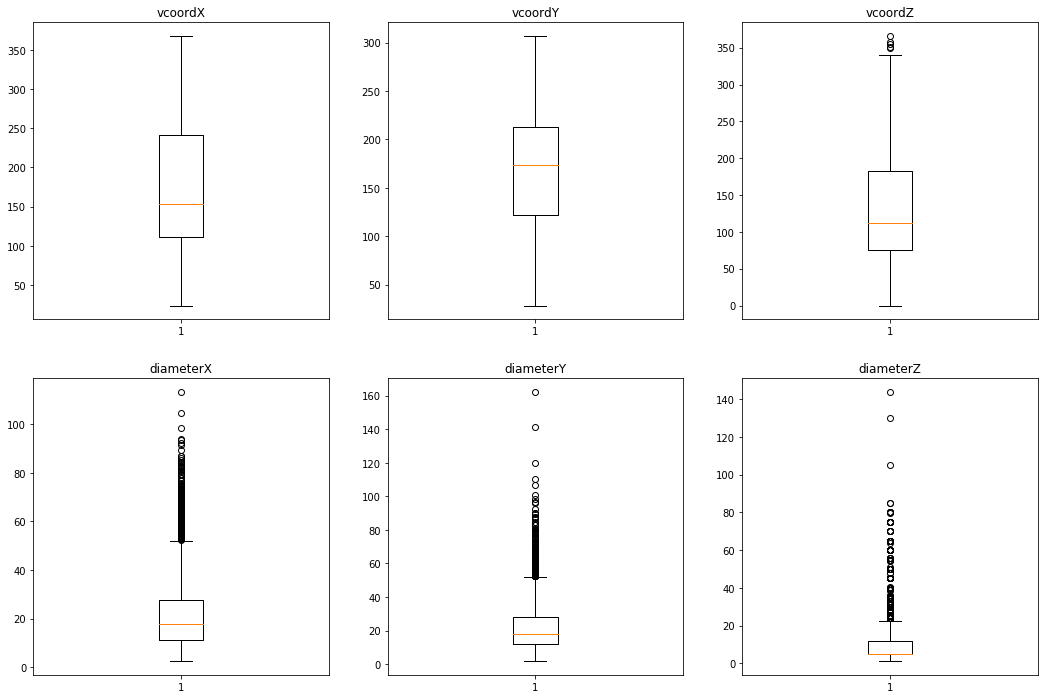

In [6]:
visual.plot_annotation(df_annotation[df_annotation['label']==5], title='annotation 索条[5]')

annotation 动脉硬化或钙化[31] (4201, 16)


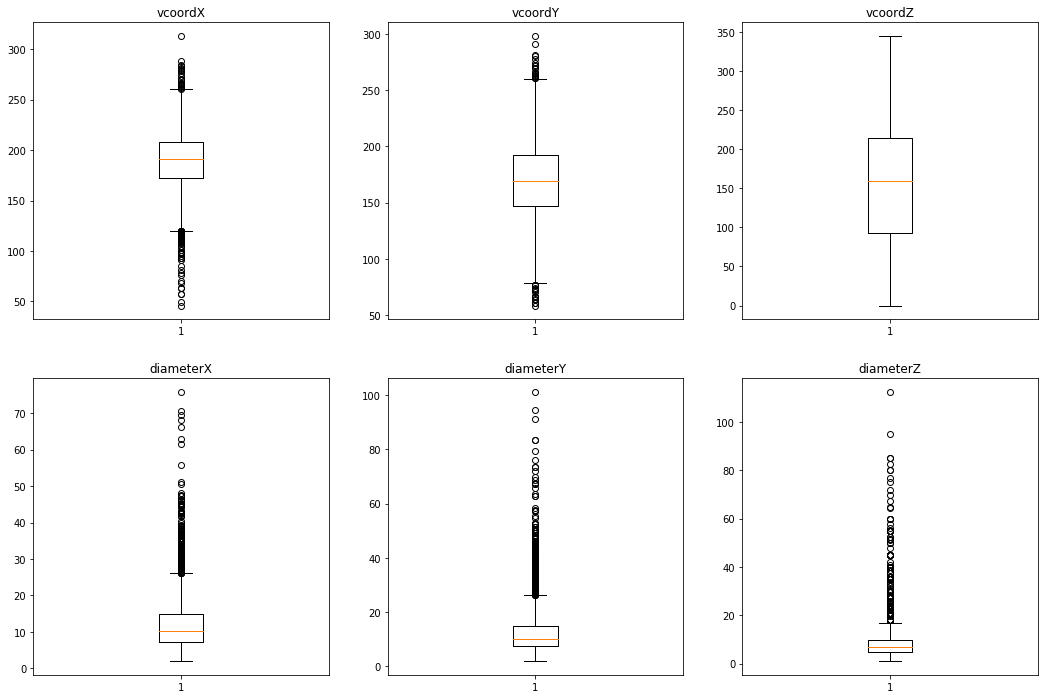

In [7]:
visual.plot_annotation(df_annotation[df_annotation['label']==31], title='annotation 动脉硬化或钙化[31]')

annotation 淋巴结钙化[32] (1140, 16)


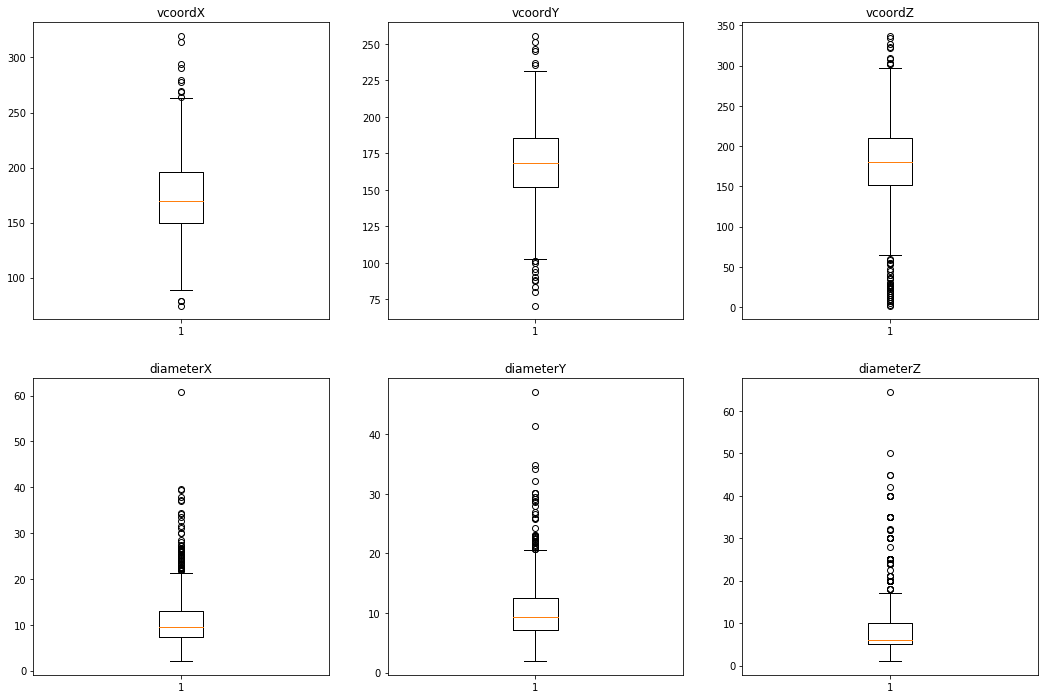

In [8]:
visual.plot_annotation(df_annotation[df_annotation['label']==32], title='annotation 淋巴结钙化[32]')

# 2. Generate Center Coords by Sliding Window

In [9]:
lungs = list(set(df_meta_train.index))
print('distinct lungs in trainset:', len(lungs))

distinct lungs in trainset: 1470


In [10]:
list_train_tasks = []
size = settings.CUBE_SIZE
step = 32
start = [ size//2, size//2, size//2 ] # z,y,x

for uid in tqdm(lungs):
    meta = df_meta_train.loc[uid] # slice
    
    for z in range(start[0], int(meta.slice), step):
        for y in range(start[1], int(meta.height), step):
            for x in range(start[2], int(meta.width), step):
                task = {}
                task['seriesuid'] = uid
                task['vcoordX'] = x
                task['vcoordY'] = y
                task['vcoordZ'] = z
                
                # print(task)
                list_train_tasks.append(task)

100%|██████████| 1470/1470 [00:04<00:00, 334.60it/s]


In [11]:
df_train_tasks = pd.DataFrame(list_train_tasks, columns=['seriesuid','vcoordX','vcoordY','vcoordZ'])
df_train_tasks = df_train_tasks.set_index('seriesuid')
df_train_tasks.index = df_train_tasks.index.astype('str')

print('total:', df_train_tasks.shape, 'lung:', len(set(df_train_tasks.index)))

if not os.path.exists(settings.SUBMISSION_DIR + f'sliding{step}'):
    os.mkdir(settings.SUBMISSION_DIR + f'sliding{step}')
    
df_train_tasks.to_csv(settings.SUBMISSION_DIR + f'sliding{step}/tasks_trainset.csv', encoding='utf-8')


total: (1381375, 3) lung: 1470


# 3. Predict Results by Task_test.csv

In [13]:
df_train_tasks = pd.read_csv(filepath_or_buffer=settings.SUBMISSION_DIR + f'sliding{step}/tasks_trainset.csv', 
                            index_col=['seriesuid'])
df_train_tasks.index = df_train_tasks.index.astype('str')

print('train tasks:', df_train_tasks.shape, 'distinct lung:', len(set(df_train_tasks.index)))


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


train tasks: (1381375, 3) distinct lung: 1470


In [14]:
df_train_tasks.sample(10)

,vcoordX,vcoordY,vcoordZ
seriesuid,,,
656373,64,192,320
680084,288,288,96
542603,320,160,256
664097,192,64,128
655557,224,224,128
627674,128,128,128
689196,64,256,256
650384,320,128,96
689153,128,160,32


In [15]:
import tensorflow.keras.backend as K
def preprocess_input(input, data_format=None):
    """Preprocesses a tensor encoding a batch of cubes.

    # Arguments
        x: input Numpy tensor, 5D. (m, d, h, w, c)
        data_format: data format of the cube tensor.

    # Returns
        Preprocessed tensor.
    """
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    # print(data_format, input.shape)

    if data_format == 'channels_first':
        if input.ndim == 4:
            input = np.expand_dims(input, axis=0)
            input[0, :, :, :] /= 255.
        else:
            input = np.expand_dims(input, axis=1)
            input[:, 0, :, :, :] /= 255.           
    else:
        input = np.expand_dims(input, axis=-1)
        input[..., 0] /= 255.

    return input

In [ ]:
from tensorflow.keras.models import load_model
output_dir = './output/densenet3d/1563443228/'
model = load_model(output_dir + "model-best.hd5")

W0719 01:16:22.315737 140153699325760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 01:16:22.317486 140153699325760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 01:16:22.324265 140153699325760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprec

In [ ]:
list_results = []
labels = [0, 1, 5, 31, 32]
for uid in tqdm(set(df_train_tasks.index)):
    tasks = df_train_tasks.loc[[uid]] # DataFrame
    meta = df_meta_train.loc[uid] # slice
    
    print(uid, len(tasks))
    print(meta)
    
    # load the lung as array
    lung, mask = helper.load_lung_array(uid, int(meta.width), int(meta.height), int(meta.slice), mode='train')
    
    # build the X_test set by tasks
    X_train = []
    for idx, item in tasks.iterrows():
        # patch without mask
        cube = helper.get_cube_from_lung_array(lung, item.vcoordX, item.vcoordY, item.vcoordZ, 
                                               block_size=settings.CUBE_SIZE)
        
        X_train.append(cube.astype('float'))
        
    X_train = preprocess_input(np.asarray(X_train))
    
    # Make predictions
    predictions_train = model.predict(X_train, batch_size=32, verbose=1)
    # print(uid, len(tasks), predictions_test.shape)
    
    # Generate the results
    for i in range(len(tasks)):
        if np.argmax(predictions_train[i]) > 0:
            category = int(np.argmax(predictions_train[i]))
            probability = float(np.max(predictions_train[i]))
            
            result = {}
            result['seriesuid'] = uid
            result['coordX'] = tasks.iloc[i].vcoordX + meta.originX
            result['coordY'] = tasks.iloc[i].vcoordY + meta.originY
            result['coordZ'] = tasks.iloc[i].vcoordZ + meta.originZ
            result['class'] = helper.get_origin_class_by_predicted_value(category, labels)
            result['probability'] = probability
            
            list_results.append(result)
            

In [ ]:
df_results = pd.DataFrame(list_results, columns=['seriesuid','coordX','coordY','coordZ','class','probability'])
df_results = df_results.set_index('seriesuid')
df_results.index = df_results.index.astype('str')

print('total:', df_results.shape, 'lung:', len(set(df_results.index)))

if not os.path.exists(settings.SUBMISSION_DIR + f'sliding{step}'):
    os.mkdir(settings.SUBMISSION_DIR + f'sliding{step}')
    
df_results.to_csv(settings.SUBMISSION_DIR + f'sliding{step}/submission.csv', encoding='utf-8')


In [ ]:
df_results = pd.read_csv(filepath_or_buffer=settings.SUBMISSION_DIR + f'sliding{step}/submission.csv', 
                            index_col=['seriesuid'])
df_results.index = df_results.index.astype('str')

print('results:', df_results.shape, 'distinct lung:', len(set(df_results.index)))


In [ ]:
df_results = df_results[df_results['probability'] > 0.7]
print(df_results.shape)

In [ ]:
df_results.to_csv(settings.SUBMISSION_DIR + f'sliding{step}/submission_filtered.csv', encoding='utf-8')